In [2]:
# 导入依赖
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet18

import matplotlib.pyplot as plt
import numpy as np

In [4]:
class _DenseLayer(nn.Module):
    """
    DenseNet 的基本构建块 - 密集连接层 (DenseLayer)
    实现了 DenseNet 的核心思想：特征重用 (feature reuse) 和特征传递 (feature propagation)
    每个层的输入都包含前面所有层的输出特征
    
    参数:
        num_input_features: 输入特征图的通道数 (包含前面所有层的输出)
        growth_rate: 增长率 (k)，控制每层输出的特征图数量
        bn_size: 瓶颈层 (bottleneck) 的扩展因子，用于控制中间特征图的维度
        drop_rate: dropout 的概率，用于正则化 (0表示不使用dropout)
    """
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        
        # 第一个批归一化层
        self.norm1 = nn.BatchNorm2d(num_input_features)
        # ReLU激活函数 (inplace=True 节省内存)
        self.relu1 = nn.ReLU(inplace=True)
        # 1x1卷积作为瓶颈层 (bottleneck)，减少计算量
        # 输出通道数为 bn_size * growth_rate
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, 
                              kernel_size=1, bias=False)
        
        # 第二个批归一化层
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        # 第二个ReLU激活函数
        self.relu2 = nn.ReLU(inplace=True)
        # 3x3卷积作为主卷积层，输出通道数为 growth_rate
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, 
                              kernel_size=3, padding=1, bias=False)
        
        # dropout率，用于正则化
        self.drop_rate = drop_rate

    def forward(self, x):
        """
        前向传播过程
        
        参数:
            x: 输入张量，形状为 (batch_size, num_input_features, height, width)
            
        返回:
            输出张量，形状为 (batch_size, num_input_features + growth_rate, height, width)
        """
        # 第一个操作序列: BN -> ReLU -> 1x1 Conv
        out = self.conv1(self.relu1(self.norm1(x)))
        
        # 第二个操作序列: BN -> ReLU -> 3x3 Conv
        out = self.conv2(self.relu2(self.norm2(out)))
        
        # 如果设置了dropout，应用dropout
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
            
        # 将输入x和本层的输出out在通道维度上拼接 (实现密集连接)
        # 这就是DenseNet的核心思想 - 特征重用
        return torch.cat([x, out], 1)  # dim=1 表示在通道维度上拼接

In [5]:
class _DenseBlock(nn.Module):
    """
    DenseNet 的核心组件 - 密集块 (DenseBlock)
    由多个密集连接层 (_DenseLayer) 组成，实现特征的多层密集连接
    
    参数:
        num_layers: 该密集块中包含的 _DenseLayer 层数
        num_input_features: 输入特征图的通道数
        bn_size: 瓶颈层的扩展因子 (控制中间特征维度)
        growth_rate: 增长率 (k)，控制每层输出的特征图数量
        drop_rate: dropout 的概率 (正则化参数)
    """
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        
        # 初始化一个空列表来存储各层
        layers = []
        
        # 构建 num_layers 个 _DenseLayer
        for i in range(num_layers):
            """
            每层的输入通道数计算:
            num_input_features + i * growth_rate
            因为每层都会增加 growth_rate 个通道，
            所以第i层的输入通道数 = 初始通道数 + 前面i层增加的通道数
            """
            layer = _DenseLayer(
                num_input_features=num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            layers.append(layer)
        
        # 将各层组合成顺序模块
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        前向传播过程
        
        参数:
            x: 输入张量，形状为 (batch_size, num_input_features, height, width)
            
        返回:
            输出张量，形状为 (batch_size, num_input_features + num_layers*growth_rate, height, width)
        """
        # 通过所有密集连接层
        return self.block(x)

In [6]:
class _Transition(nn.Module):
    """
    DenseNet 的过渡层 (Transition Layer)
    用于连接两个密集块(DenseBlock)，主要功能是压缩特征图尺寸和通道数
    
    参数:
        num_input_features: 输入特征图的通道数
        num_output_features: 输出特征图的通道数 (通常小于输入通道数)
    """
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        
        # 批归一化层
        self.norm = nn.BatchNorm2d(num_input_features)
        
        # ReLU激活函数 (inplace=True 节省内存)
        self.relu = nn.ReLU(inplace=True)
        
        # 1x1卷积用于压缩通道数
        # 从num_input_features压缩到num_output_features
        self.conv = nn.Conv2d(num_input_features, 
                             num_output_features, 
                             kernel_size=1, 
                             bias=False)
        
        # 2x2平均池化，步长=2，使特征图尺寸减半
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        前向传播过程
        
        参数:
            x: 输入张量，形状为 (batch_size, num_input_features, height, width)
            
        返回:
            输出张量，形状为 (batch_size, num_output_features, height/2, width/2)
        """
        # 操作序列: BN -> ReLU -> 1x1 Conv -> AvgPool
        x = self.conv(self.relu(self.norm(x)))
        return self.pool(x)

In [7]:
class DenseNet(nn.Module):
    """
    DenseNet 完整网络实现
    
    参数:
        growth_rate (int): 增长率k，控制每层输出的特征图数量 (默认12)
        block_config (tuple): 每个dense block的层数配置 (默认(6,12,24,16))
        num_init_features (int): 初始卷积层的输出通道数 (默认64)
        bn_size (int): 瓶颈层的扩展因子 (默认4)
        drop_rate (float): dropout概率 (默认0)
        num_classes (int): 分类任务的类别数 (默认10)
    """
    def __init__(self, growth_rate=12, block_config=(6,12,24,16), 
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=10):
        super(DenseNet, self).__init__()
        
        # 初始特征提取部分 (卷积+BN+ReLU)
        self.features = nn.Sequential(
            # 初始卷积层: 3通道输入(RGB), kernel_size=3, padding=1保持尺寸
            nn.Conv2d(3, num_init_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True)
        )
        
        # 初始化特征通道数
        num_features = num_init_features
        blocks = []
        
        # 构建多个DenseBlock和Transition层
        for i, num_layers in enumerate(block_config):
            # 添加DenseBlock
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            blocks.append(block)
            
            # 更新特征通道数 (每个DenseLayer增加growth_rate个通道)
            num_features += num_layers * growth_rate
            
            # 如果不是最后一个block，添加Transition层
            if i != len(block_config)-1:
                trans = _Transition(
                    num_input_features=num_features,
                    num_output_features=num_features // 2  # 压缩率0.5
                )
                blocks.append(trans)
                num_features = num_features // 2  # 更新通道数
        
        # 将所有block和transition组合成Sequential
        self.features.add_module("dense_blocks", nn.Sequential(*blocks))
        
        # 最终批归一化层
        self.features.add_module("norm_final", nn.BatchNorm2d(num_features))
        
        # 分类器 (全连接层)
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        """
        前向传播过程
        
        参数:
            x: 输入图像张量，形状为 (batch_size, 3, height, width)
            
        返回:
            分类得分，形状为 (batch_size, num_classes)
        """
        # 特征提取
        x = self.features(x)
        
        # 最终ReLU激活
        x = F.relu(x)
        
        # 全局平均池化 (将特征图降为1x1)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # 展平特征 (batch_size, num_features, 1, 1) -> (batch_size, num_features)
        x = x.view(x.size(0), -1)
        
        # 分类器
        return self.classifier(x)

In [9]:
# 定义数据预处理流程
transform = transforms.Compose([
    # 随机水平翻转 (数据增强)
    transforms.RandomHorizontalFlip(),
    # 将PIL图像或numpy数组转换为torch张量
    # 并自动将像素值从[0,255]归一化到[0,1]
    transforms.ToTensor()
])

# 加载CIFAR-10训练集
dataset = torchvision.datasets.CIFAR10(
    root='../../../Data',  # 数据集存储路径
    train=True,            # 加载训练集
    download=True,         # 如果数据集不存在则自动下载
    transform=transform    # 应用定义的数据预处理
)

# 划分训练集和验证集 (80%训练, 20%验证)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# 加载CIFAR-10测试集
test_set = torchvision.datasets.CIFAR10(
    root='../../../Data',
    train=False,           # 加载测试集
    download=True,
    transform=transform    # 应用相同的预处理
)

# 创建数据加载器
train_loader = DataLoader(
    train_set,
    batch_size=64,   # 每个batch包含64张图像
    shuffle=True     # 每个epoch打乱数据顺序
)

val_loader = DataLoader(
    val_set,
    batch_size=64,   # 验证集batch大小
    shuffle=False    # 验证集不需要打乱
)

test_loader = DataLoader(
    test_set,
    batch_size=100,  # 测试集batch大小
    shuffle=False    # 测试集不需要打乱
)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(num_classes=10).to(device)
densenet = DenseNet(num_classes=10).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_densenet = torch.optim.SGD(densenet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.1)
scheduler_densenet = torch.optim.lr_scheduler.StepLR(optimizer_densenet, step_size=10, gamma=0.1)

In [13]:
def train_epoch(model, loader, optimizer):
    """
    执行一个完整的训练epoch
    
    参数:
        model: 要训练的模型
        loader: 训练数据加载器
        optimizer: 优化器
    
    返回:
        avg_loss: 该epoch的平均损失
        accuracy: 该epoch的训练准确率(%)
    """
    # 将模型设置为训练模式 (启用dropout/batchnorm等训练特定行为)
    model.train()
    
    # 初始化统计变量
    total_loss = 0.0  # 累计损失
    correct = 0       # 正确预测数
    total = 0         # 总样本数
    
    # 遍历数据加载器中的所有batch
    for inputs, targets in loader:
        # 将数据移动到指定设备(CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 清零优化器的梯度 (避免梯度累积)
        optimizer.zero_grad()
        
        # 前向传播: 计算模型输出
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, targets)
        
        # 反向传播: 计算梯度
        loss.backward()
        
        # 优化器更新模型参数
        optimizer.step()
        
        # 统计信息更新
        total_loss += loss.item()  # 累加损失值
        
        # 计算预测结果 (取最大概率的类别)
        _, preds = outputs.max(1)
        
        # 统计正确预测数
        correct += preds.eq(targets).sum().item()
        
        # 统计总样本数
        total += targets.size(0)
    
    # 计算平均损失和准确率
    avg_loss = total_loss / len(loader)          # 平均损失 = 总损失 / batch数量
    accuracy = 100. * correct / total           # 准确率 = 正确数 / 总数
    
    return avg_loss, accuracy

In [14]:
def eval_epoch(model, loader):
    """
    执行模型评估(验证/测试)
    
    参数:
        model: 要评估的模型
        loader: 评估数据加载器(验证集或测试集)
    
    返回:
        avg_loss: 平均损失
        accuracy: 准确率(%)
    """
    # 将模型设置为评估模式 (禁用dropout/batchnorm的特定行为)
    model.eval()
    
    # 初始化统计变量
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 禁用梯度计算 (节省内存和计算资源)
    with torch.no_grad():
        # 遍历所有batch
        for inputs, targets in loader:
            # 数据移动到设备
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 统计信息更新
            total_loss += loss.item()
            
            # 计算预测结果
            _, preds = outputs.max(1)
            
            # 统计正确预测数
            correct += preds.eq(targets).sum().item()
            
            # 统计总样本数
            total += targets.size(0)
    
    # 计算平均指标
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

In [16]:
epochs = 20
history = {"resnet_train": [], "resnet_val": [], "densenet_train": [], "densenet_val": []}

for epoch in range(1, epochs+1):
    r_train_loss, r_train_acc = train_epoch(resnet, train_loader, optimizer_resnet)
    r_val_loss, r_val_acc = eval_epoch(resnet, val_loader)

    d_train_loss, d_train_acc = train_epoch(densenet, train_loader, optimizer_densenet)
    d_val_loss, d_val_acc = eval_epoch(densenet, val_loader)

    scheduler_resnet.step()
    scheduler_densenet.step()

    print(f"Epoch {epoch}")
    print(f" ResNet Train: loss={r_train_loss:.3f} acc={r_train_acc:.2f}% | Val: loss={r_val_loss:.3f} acc={r_val_acc:.2f}%")
    print(f" DenseNet Train: loss={d_train_loss:.3f} acc={d_train_acc:.2f}% | Val: loss={d_val_loss:.3f} acc={d_val_acc:.2f}%")

    history["resnet_train"].append(r_train_acc)
    history["resnet_val"].append(r_val_acc)
    history["densenet_train"].append(d_train_acc)
    history["densenet_val"].append(d_val_acc)


Epoch 1
 ResNet Train: loss=0.934 acc=67.59% | Val: loss=1.380 acc=55.43%
 DenseNet Train: loss=0.628 acc=78.38% | Val: loss=1.425 acc=55.69%
Epoch 2
 ResNet Train: loss=0.898 acc=69.15% | Val: loss=0.975 acc=66.64%
 DenseNet Train: loss=0.599 acc=79.14% | Val: loss=0.700 acc=75.93%
Epoch 3
 ResNet Train: loss=0.861 acc=70.17% | Val: loss=1.221 acc=58.50%
 DenseNet Train: loss=0.587 acc=79.75% | Val: loss=0.633 acc=78.27%
Epoch 4
 ResNet Train: loss=0.842 acc=70.80% | Val: loss=1.260 acc=58.17%
 DenseNet Train: loss=0.570 acc=80.39% | Val: loss=0.877 acc=69.73%
Epoch 5
 ResNet Train: loss=0.822 acc=71.64% | Val: loss=1.236 acc=59.32%
 DenseNet Train: loss=0.557 acc=80.75% | Val: loss=0.814 acc=72.53%
Epoch 6
 ResNet Train: loss=0.556 acc=80.99% | Val: loss=0.644 acc=77.64%
 DenseNet Train: loss=0.346 acc=88.36% | Val: loss=0.352 acc=87.74%
Epoch 7
 ResNet Train: loss=0.465 acc=83.98% | Val: loss=0.620 acc=78.43%
 DenseNet Train: loss=0.280 acc=90.58% | Val: loss=0.329 acc=88.47%
Epoch 

In [17]:
torch.save(resnet.state_dict(), "resnet_cifar10.pth")
torch.save(densenet.state_dict(), "densenet_cifar10.pth")
print("模型权重已保存")

模型权重已保存


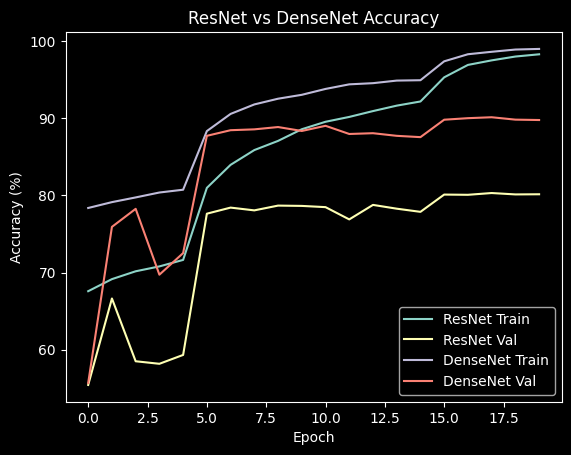

In [18]:
plt.plot(history["resnet_train"], label="ResNet Train")
plt.plot(history["resnet_val"], label="ResNet Val")
plt.plot(history["densenet_train"], label="DenseNet Train")
plt.plot(history["densenet_val"], label="DenseNet Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("ResNet vs DenseNet Accuracy")
plt.show()


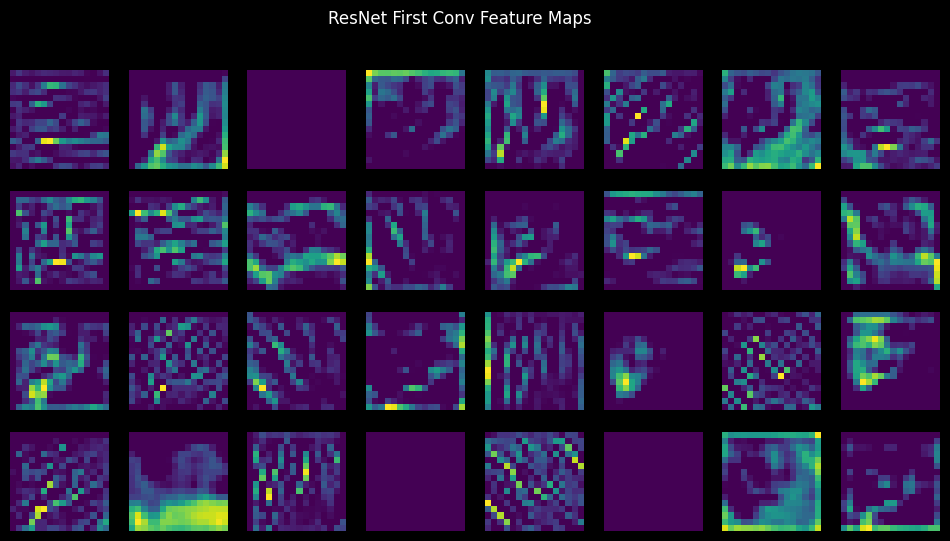

In [19]:
def visualize_features(model, input_tensor):
    model.eval()
    with torch.no_grad():
        x = input_tensor.to(device)
        # 第一个卷积层
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        # x.shape = [1, 64, 32, 32]
        features = x.cpu().squeeze(0)
        fig, axes = plt.subplots(4, 8, figsize=(12,6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(features[i], cmap='viridis')
            ax.axis('off')
        plt.suptitle("ResNet First Conv Feature Maps")
        plt.show()

# 随机一张图
sample, _ = test_set[0]
sample = sample.unsqueeze(0)
visualize_features(resnet, sample)
